### Total Revenue Per Day

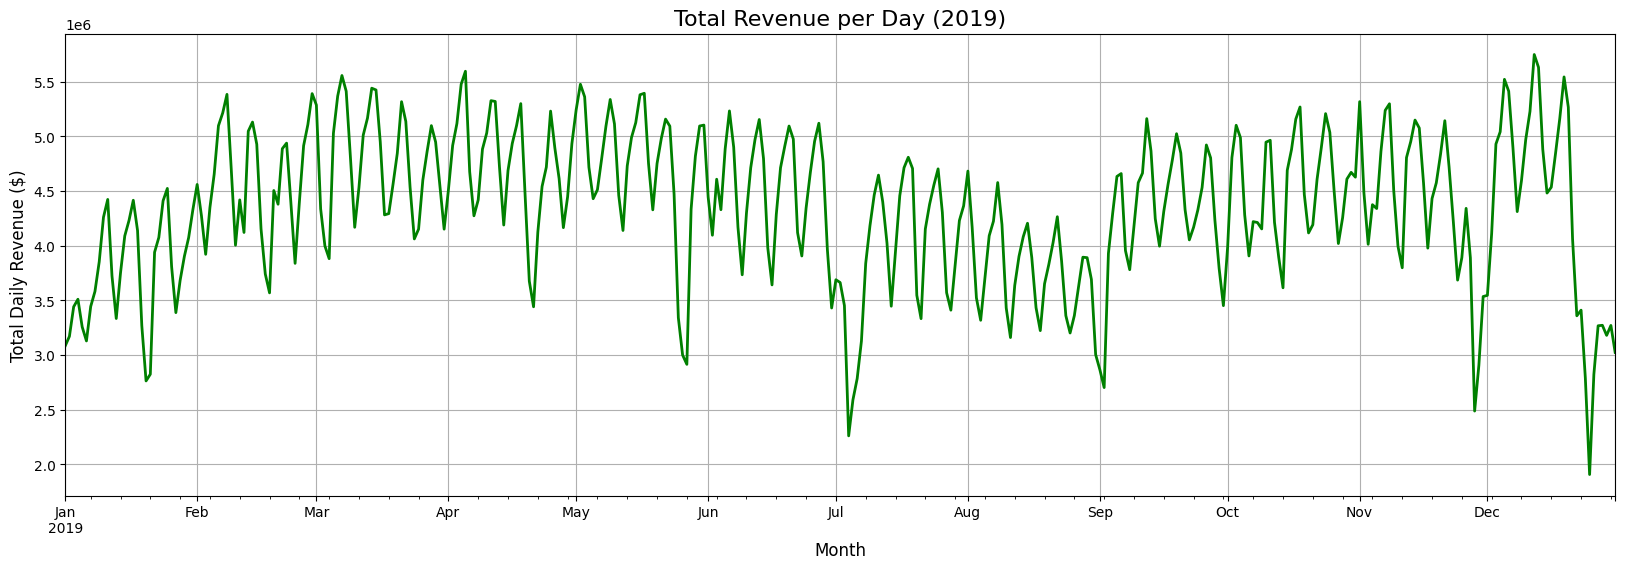

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../processed/kpi_daily_2019.csv")
df['date'] = pd.to_datetime(df['date'])

df_plot = df.pivot_table(
    index='date',
    values='total_money',
    aggfunc='sum'
)

fig, ax = plt.subplots(figsize=(20, 6))

df_plot.plot(kind='line', color='green', linewidth=2, ax=ax, legend=False)

start_date = pd.Timestamp('2019-01-01')
end_date   = pd.Timestamp('2019-12-31')

ax.set_xlim(start_date, end_date)

# print(f"Max daily revenue: ${df_plot['total_money'].max():,.2f}, on {df_plot['total_money'].idxmax().date()}")
# print(f"Min daily revenue: ${df_plot['total_money'].min():,.2f}, on {df_plot['total_money'].idxmin().date()}")


ax.set_title('Total Revenue per Day (2019)', fontsize=16)
ax.set_ylabel('Total Daily Revenue ($)', fontsize=12)
ax.set_xlabel('Month', fontsize=12)
ax.grid(True)

plt.show()

Điểm đáy của đồ thị trên là các ngày lễ lớn -> Ít sử dụng dịch vụ taxi hơn
- 4/7: Independence Day
- 27/11: Thanksgiving Day
- 25/12: Christmas Day

### Total Revenue per Day & Total Trips per Day
We can see similar trends

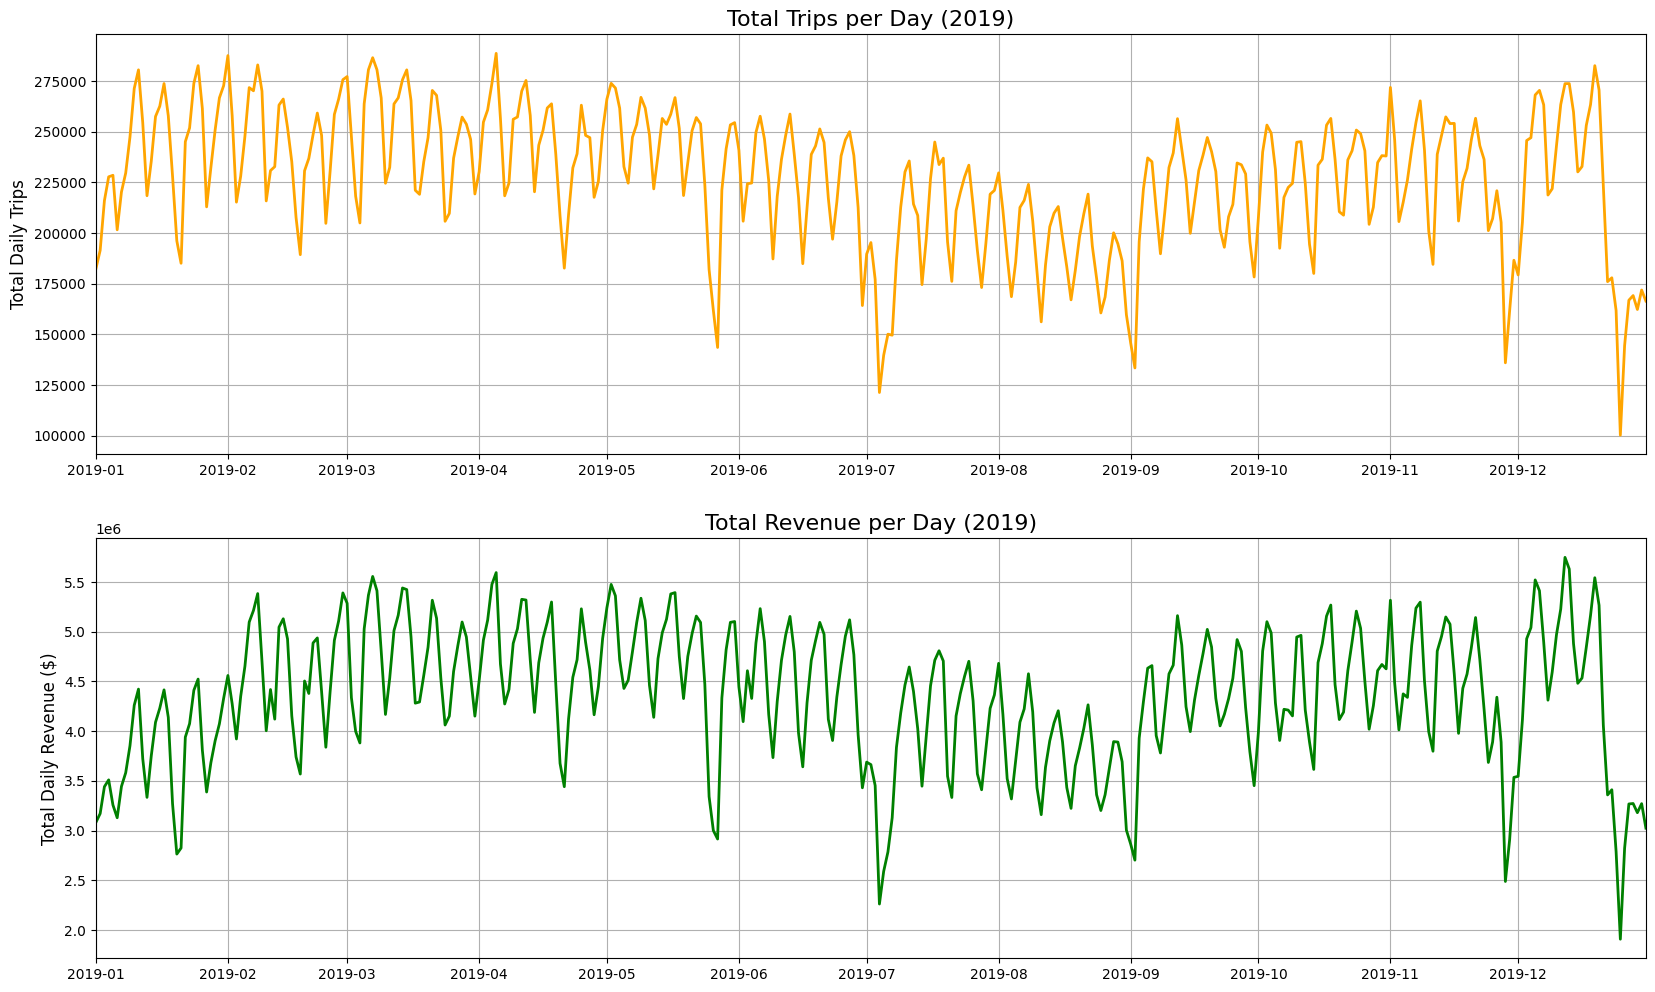

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../processed/kpi_daily_2019.csv")
df['date'] = pd.to_datetime(df['date'])

fig, ax = plt.subplots(2, 1, figsize=(20, 12))
start_date = pd.Timestamp('2019-01-01')
end_date   = pd.Timestamp('2019-12-31')

ax[0].plot(df['date'], df['trips'], color='orange', linewidth=2)
ax[0].set_xlim(start_date, end_date)
ax[0].set_title('Total Trips per Day (2019)', fontsize=16)
ax[0].set_ylabel('Total Daily Trips', fontsize=12)
ax[0].grid(True)

ax[1].plot(df['date'], df['total_money'], color='green', linewidth=2)
ax[1].set_xlim(start_date, end_date)
ax[1].set_title('Total Revenue per Day (2019)', fontsize=16)
ax[1].set_ylabel('Total Daily Revenue ($)', fontsize=12)
ax[1].grid(True)

plt.show()

Same graph but Dual Axis (Combine 2 graphs together)

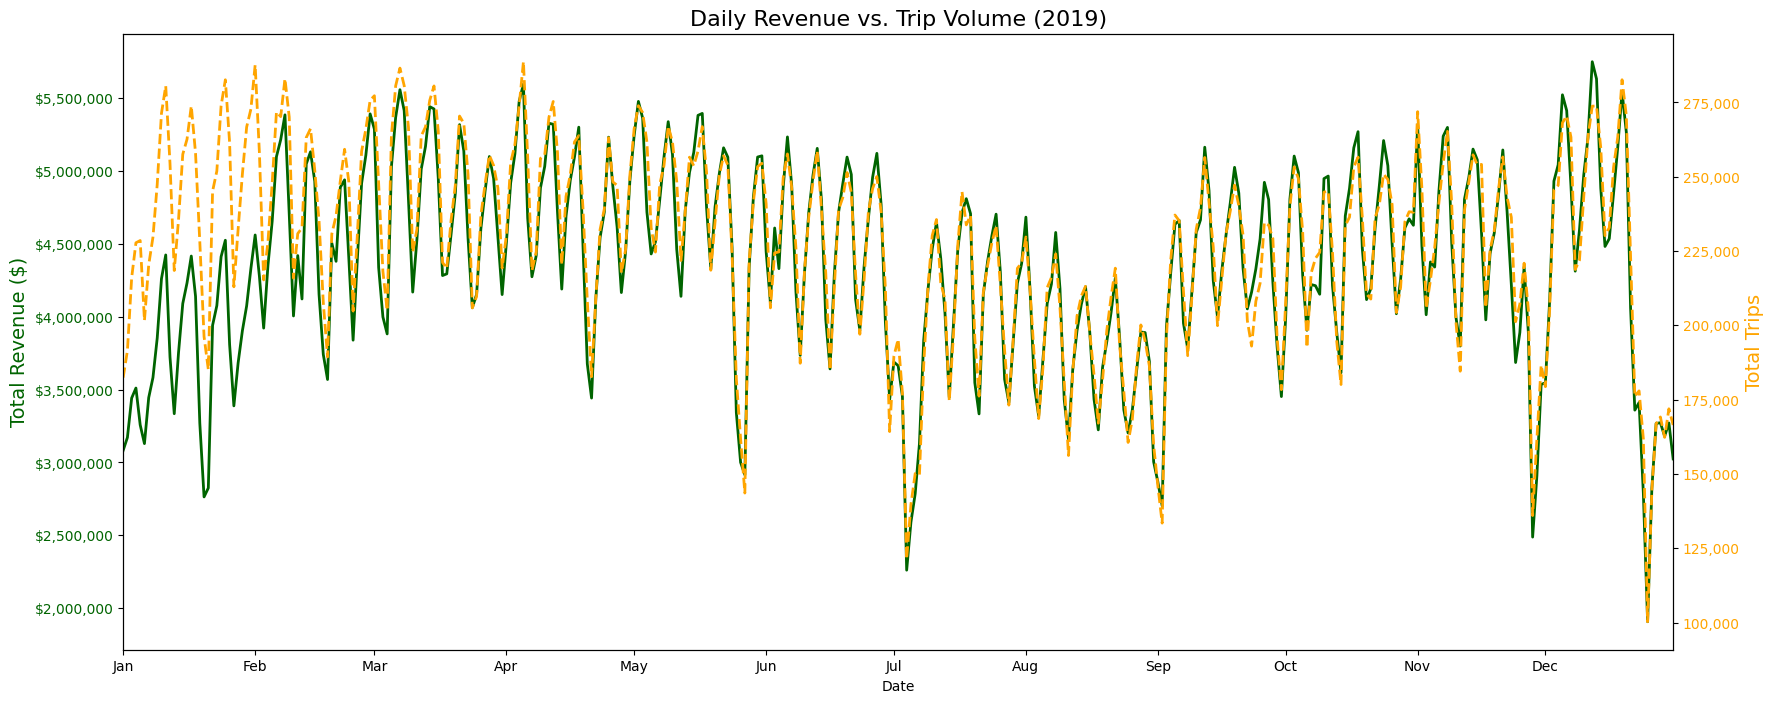

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick # For currency formatting
import matplotlib.dates as mdates # For time formatting

df = pd.read_csv('../processed/kpi_daily_2019.csv')
df['date'] = pd.to_datetime(df['date'])

fig, ax1 = plt.subplots(figsize=(20, 8))

# Revenue
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Revenue ($)', color='darkgreen', fontsize=14)
ax1.plot(df['date'], df['total_money'], color='darkgreen', linewidth=2, linestyle='-')
ax1.tick_params(axis='y', labelcolor='darkgreen')
ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))


# Trips
ax2 = ax1.twinx()
ax2.set_ylabel('Total Trips', color='orange', fontsize=14)
ax2.plot(df['date'], df['trips'], color='orange', linewidth=2, linestyle='--')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))


plt.title('Daily Revenue vs. Trip Volume (2019)', fontsize=16)
# plt.grid(True, alpha=0.2)
ax1.set_xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2019-12-31'))
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# plt.savefig('../figures/revenue_vs_trip.png')
plt.show()

Can easily see that 2 graphs are almost identical

But in the January and first two weeks of Febuary: Total Trips does not overlap Total Money -> Less Revenue per Trip

### Trip Volume by Payment Type per Month

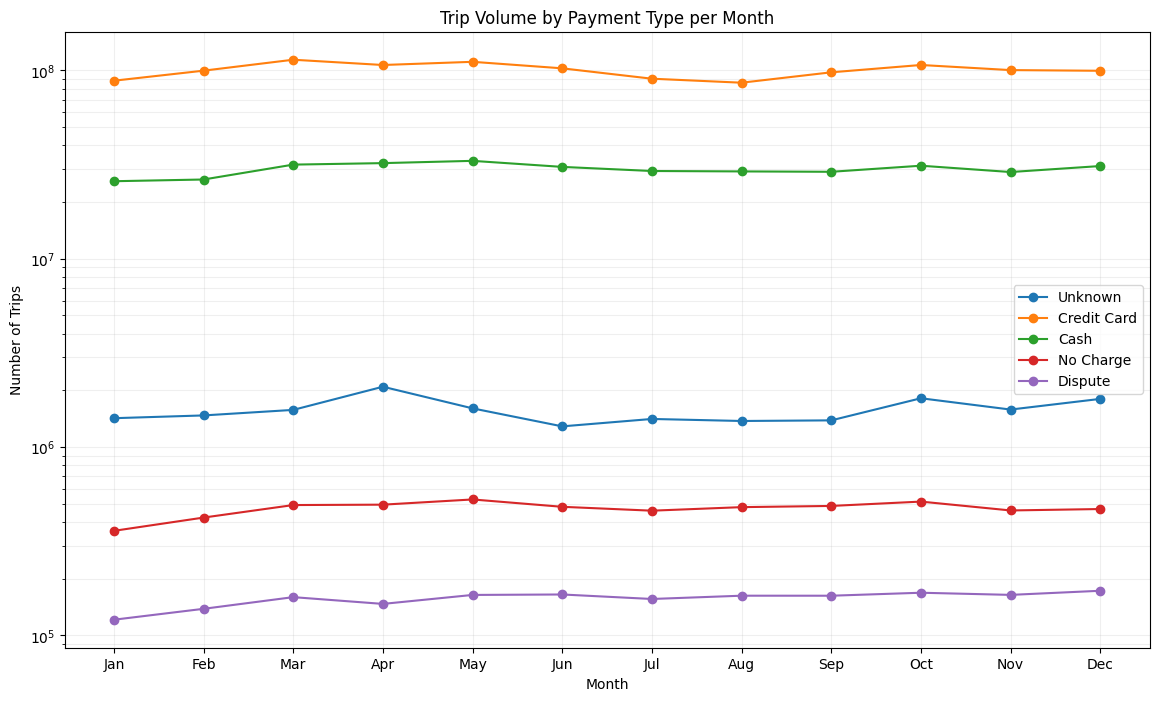

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('../processed/kpi_monthly_payment_type_2019.csv')

df_plot = df.pivot_table(
    index='month', 
    columns='payment_type', 
    values='total_money', 
    aggfunc='sum'
)

payment_labels = {
    0: 'Unknown',
    1: 'Credit Card',
    2: 'Cash',
    3: 'No Charge',
    4: 'Dispute'
}

plt.figure(figsize=(14, 8))

for p_type in range(0, 5):
    if p_type in df_plot.columns:
        plt.plot(
            df_plot[p_type], 
            marker='o', 
            label=payment_labels.get(p_type)
        )

plt.title('Trip Volume by Payment Type per Month')

plt.yscale('log') # Log scale
plt.ylabel('Number of Trips')

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(ticks=list(range(0, 12)), labels=months)
plt.xlabel('Month')

plt.legend()
plt.grid(True, which='both', alpha=0.2)

# plt.savefig('../figures/trip_payment_type_month.png')
plt.show()

Credit Card & Cash are the most commonly used methods for payment

### Trips per Pick Up and Drop Off Locations
Using Pareto Chart

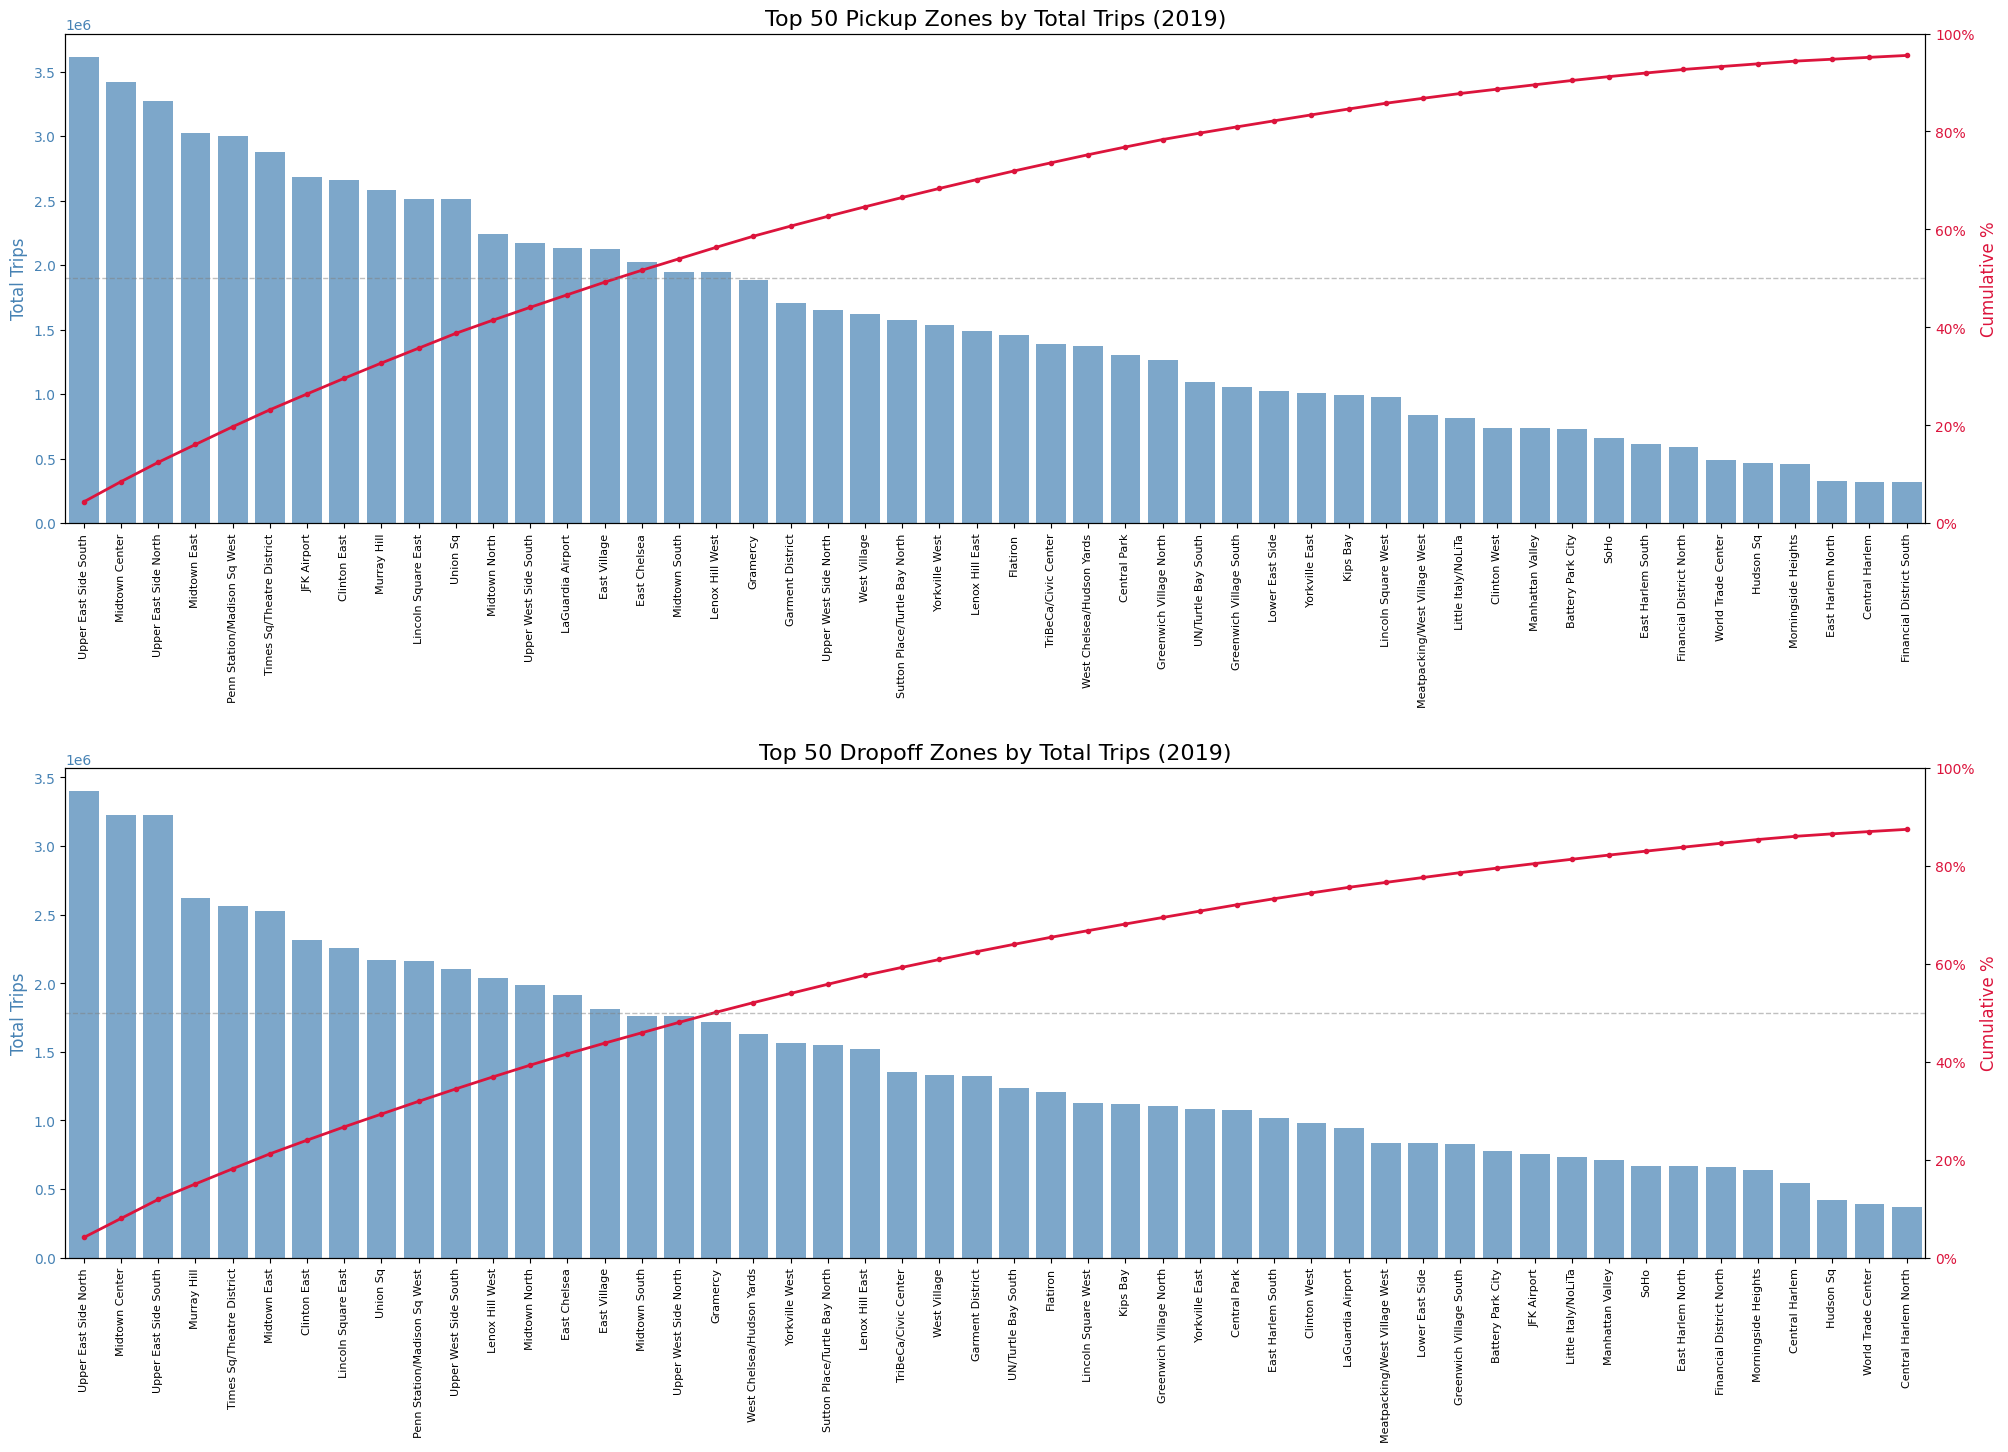

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

df_pu = pd.read_csv('../processed/kpi_monthly_pickup_2019.csv')
df_do = pd.read_csv('../processed/kpi_monthly_dropoff_2019.csv')
df_lookup = pd.read_csv('../raw/taxi_zone_lookup.csv')

zone_map = dict(zip(df_lookup['LocationID'], df_lookup['Zone']))

def get_pareto_data_with_names(df, loc_col, value_col='trips'):
    df_agg = df.groupby(loc_col)[value_col].sum().sort_values(ascending=False).reset_index()

    total_volume = df_agg[value_col].sum()
    df_agg['cumulative_pct'] = (df_agg[value_col].cumsum() / total_volume) * 100
    
    df_agg['zone_name'] = df_agg[loc_col].map(zone_map)
    
    return df_agg

pu_data = get_pareto_data_with_names(df_pu, 'PULocationID')
do_data = get_pareto_data_with_names(df_do, 'DOLocationID')

def plot_pareto(ax, df, title, top_n=50):
    df_plot = df.head(top_n)
    
    x_labels = df_plot['zone_name']
    x_positions = range(len(df_plot))

    # Bar Chart (Left Axis)
    ax.bar(x_positions, df_plot['trips'], color='steelblue', alpha=0.7, label='Volume')
    ax.set_ylabel('Total Trips', color='steelblue', fontsize=12)
    ax.tick_params(axis='y', labelcolor='steelblue')
    
    # Line Chart (Right Axis)
    ax2 = ax.twinx()
    ax2.plot(x_positions, df_plot['cumulative_pct'], color='crimson', marker='o', markersize=3, linewidth=2)
    ax2.set_ylabel('Cumulative %', color='crimson', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='crimson')
    
    # Formatting
    ax2.set_ylim(0, 100)
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax2.axhline(50, color='gray', linestyle='--', linewidth=1, alpha=0.5)

    ax.set_title(title, fontsize=16)
    
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, rotation=90, fontsize=8, ha='center') 
    ax.set_xlim(-0.5, len(df_plot)-0.5) # Remove gaps at edges


fig, axes = plt.subplots(2, 1, figsize=(24, 18))

plot_pareto(axes[0], pu_data, f'Top 50 Pickup Zones by Total Trips (2019)')
plot_pareto(axes[1], do_data, f'Top 50 Dropoff Zones by Total Trips (2019)')

# Make room for labels
plt.subplots_adjust(bottom=0.2, hspace=0.5) 

# plt.savefig('../figures/pu_do_zones_by_total_trips.png')
plt.show()

Approximately 15 Locations make up for 50% of Total Trips recorded

### Speed Mean per Hour (Congestion Index)

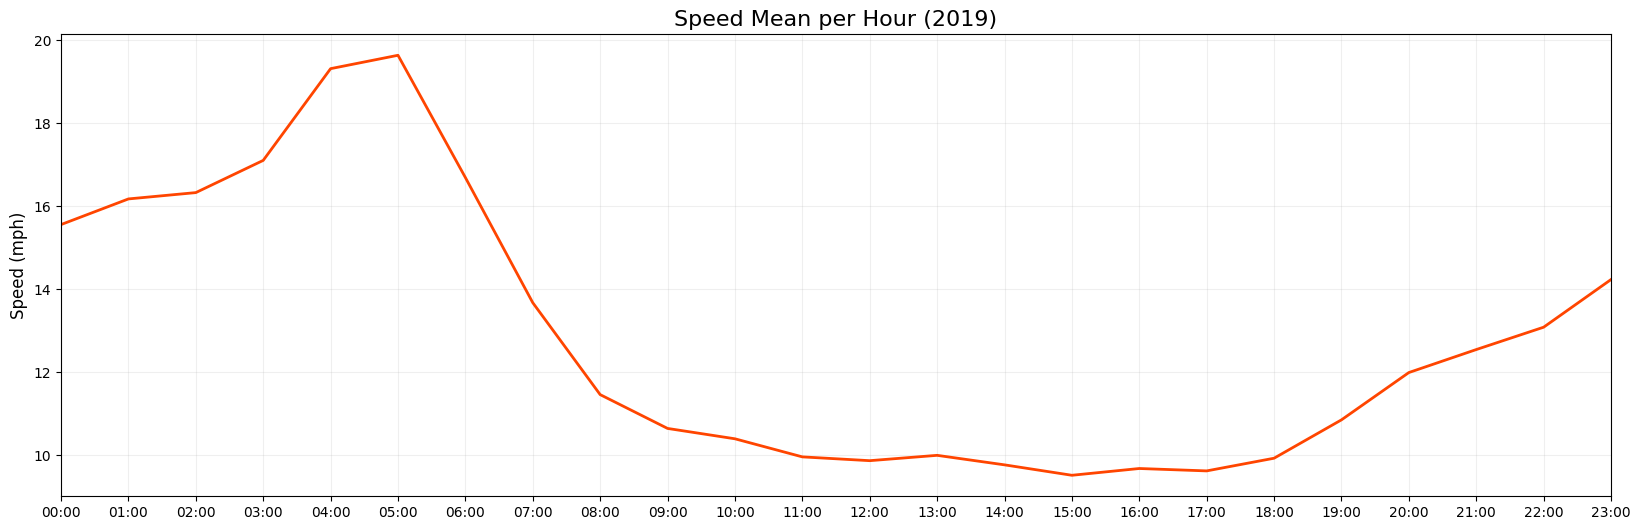

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../processed/kpi_hourly_2019.csv")

df = df.groupby('hour').agg(
    speed_mean=('speed_mean', 'mean')
).reset_index()

# print(df)

fig, ax = plt.subplots(figsize=(20, 6))

df.plot(kind='line', x='hour', y='speed_mean', color='orangered', linewidth=2, ax=ax, legend=False)

ax.set_title('Speed Mean per Hour (2019)', fontsize=16)

ax.grid(True, alpha=0.2)
ax.set_ylabel('Speed (mph)', fontsize=12)

ax.set_xlabel(None)
ax.set_xticks(ticks=range(24), labels=[f'{h:02d}:00' for h in range(24)])
ax.set_xlim(0, 23)

# plt.savefig('../figures/speed_mean_per_hour.png')
plt.show()

### Trips per Day of the Week

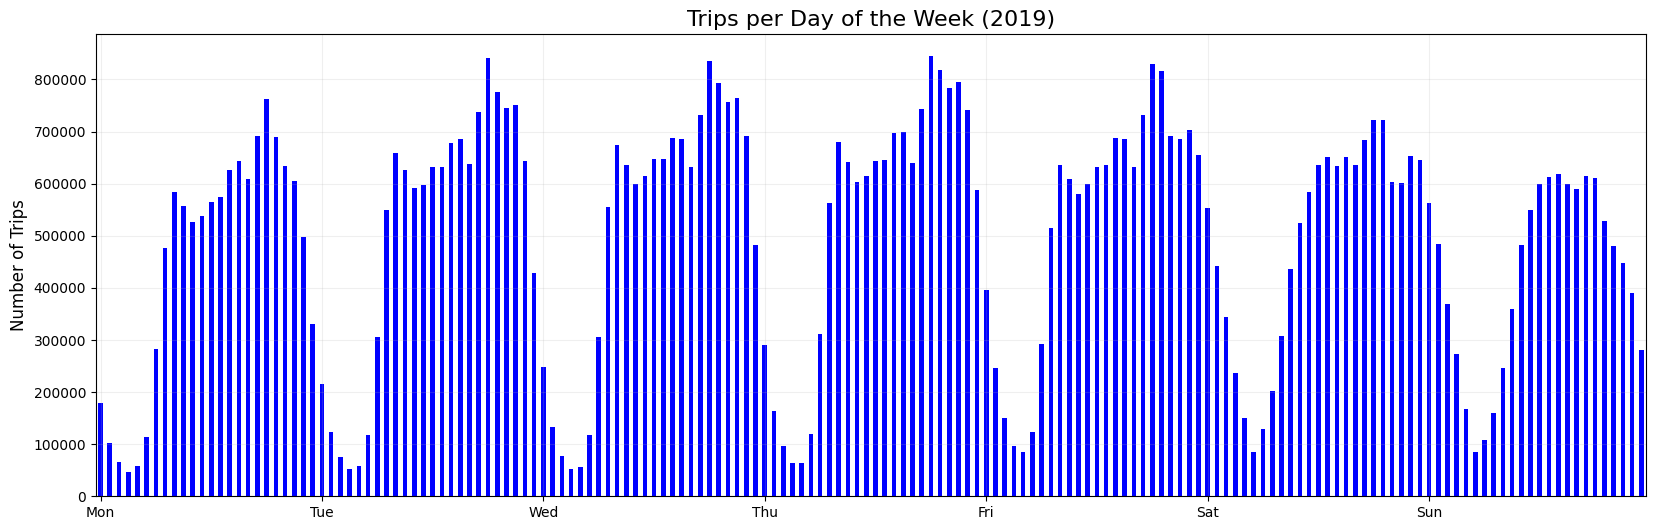

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../processed/kpi_hourly_2019.csv")

# print(df)

fig, ax = plt.subplots(figsize=(20, 6))

df.plot(kind='bar', x='dow', y='trips', color='blue', width=0.5, ax=ax, legend=False)

ax.set_title('Trips per Day of the Week (2019)', fontsize=16)
ax.grid(True, alpha=0.2)

ax.set_ylabel('Number of Trips', fontsize=12)

ax.set_xlabel(None)
ax.set_xticks(ticks=[24*i for i in range(7)], labels=list(df['day'].unique()), rotation=0)

# plt.savefig('../figures/trip_per_dow.png')
plt.show()

### Revenue vs Trips per Hour

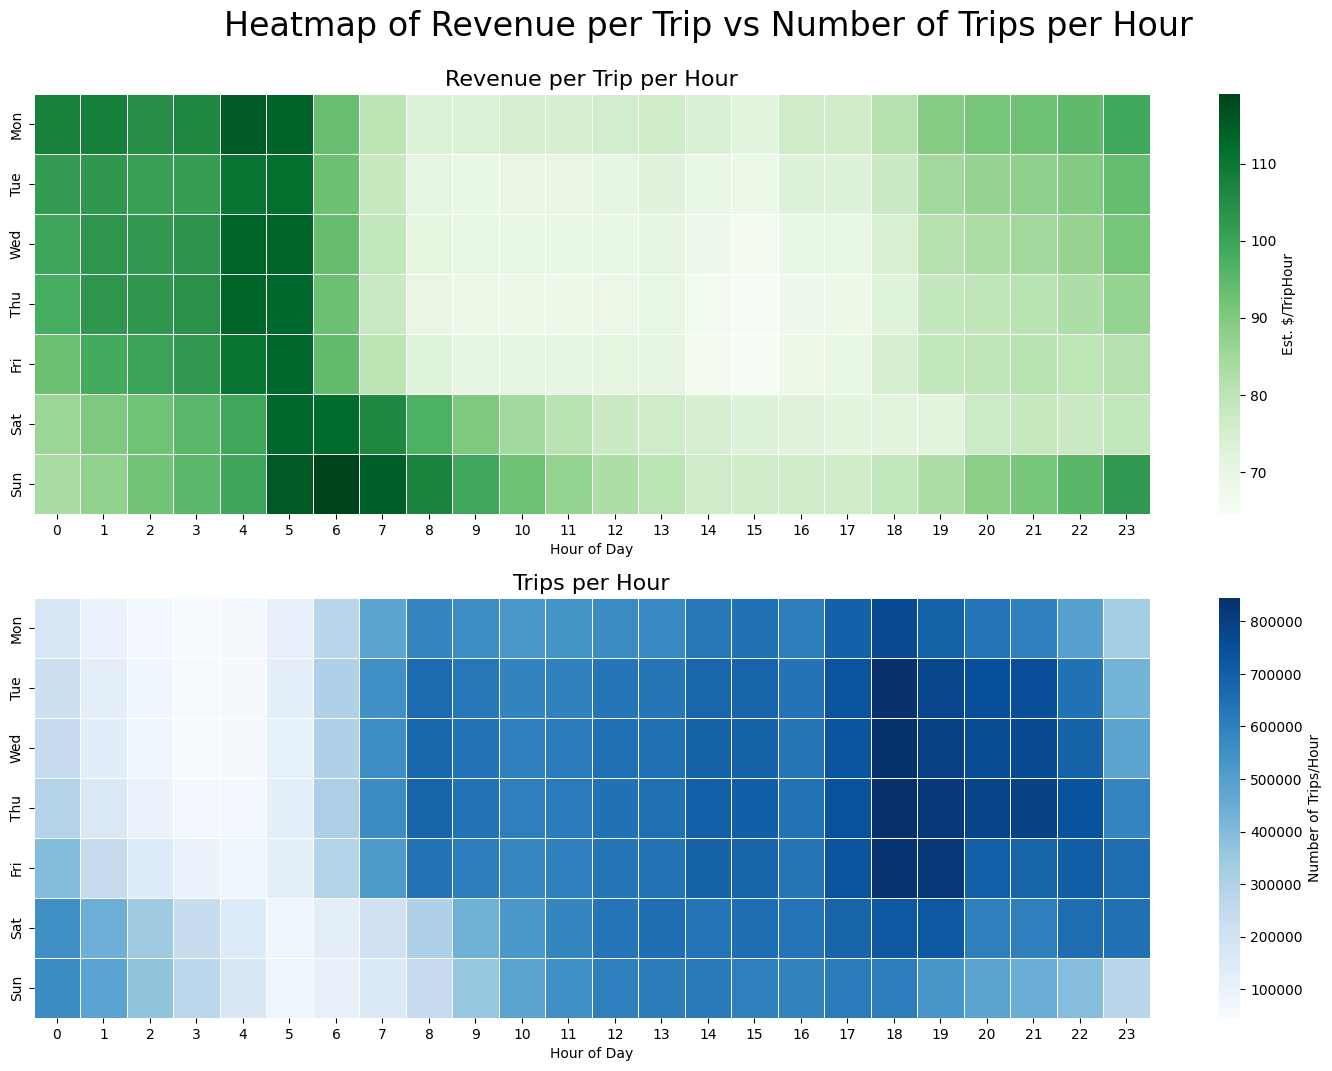

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('../processed/kpi_hourly_2019.csv')

df['hourly_rev'] = df['total_money'] / df['trips'] * 60 / df['duration_mean']
df_plot = df.pivot(index='day', columns='hour', values='hourly_rev').reindex(list(df['day'].unique()))

fig, ax = plt.subplots(2, 1, figsize=(18, 12))

sns.heatmap(df_plot, ax=ax[0], cmap='Greens', linewidths=0.5, cbar_kws={'label': 'Est. $/TripHour'})
ax[0].set_title('Revenue per Trip per Hour', fontsize=16)
ax[0].set_ylabel(None)
ax[0].set_xlabel('Hour of Day')

df_plot = df.pivot(index='day', columns='hour', values='trips').reindex(list(df['day'].unique()))

sns.heatmap(df_plot, ax=ax[1], cmap='Blues', linewidths=0.5, cbar_kws={'label': 'Number of Trips/Hour'})
ax[1].set_title('Trips per Hour', fontsize=16)
ax[1].set_ylabel(None)
ax[1].set_xlabel('Hour of Day')

fig.suptitle('Heatmap of Revenue per Trip vs Number of Trips per Hour', fontsize=24, y=0.95)

# plt.savefig('../figures/rev_vs_trip_hour.png')
plt.show()

### Daily Distance Mean

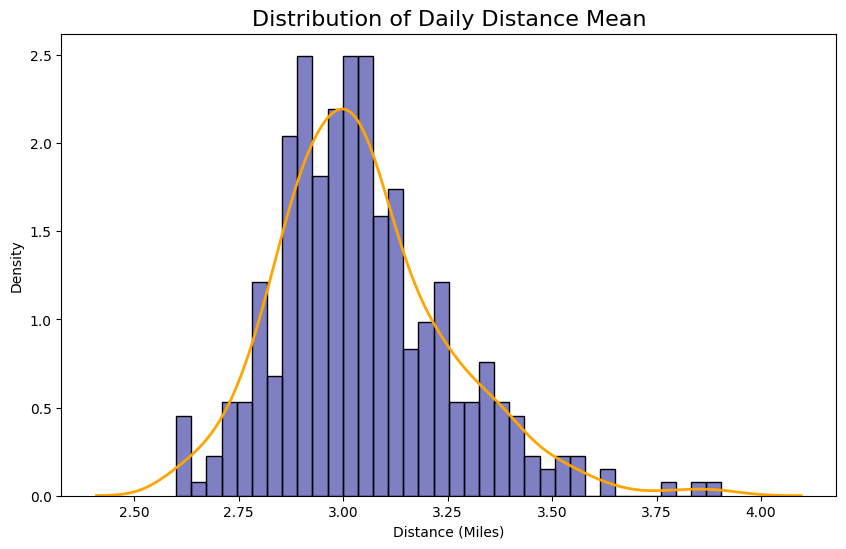

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('../processed/kpi_daily_2019.csv')

plt.figure(figsize=(10, 6))

sns.histplot(df['distance_mean'], bins=36, color='darkblue', stat='density', alpha=0.5)
sns.kdeplot(df['distance_mean'], color='orange', linewidth=2)

plt.title('Distribution of Daily Distance Mean', fontsize=16)
plt.xlabel('Distance (Miles)')

# plt.savefig('../figures/daily_distance_mean.png')
plt.show()

### Trip Duration P50 vs P95

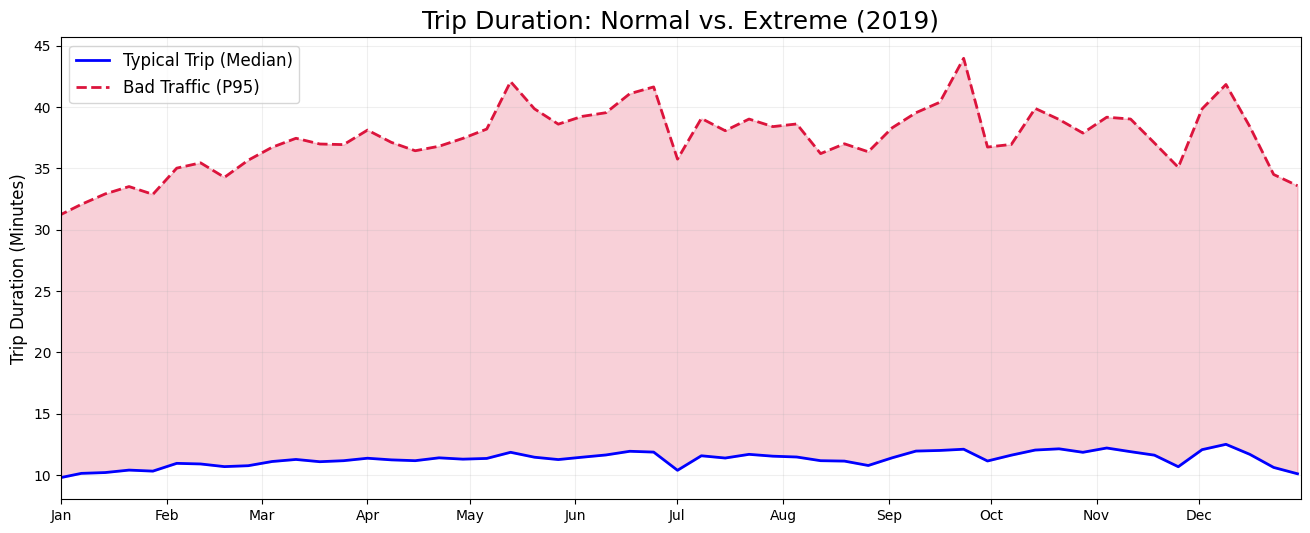

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df = pd.read_csv('../processed/kpi_weekly_2019.csv')

df['week_start'] = pd.to_datetime(df['week_start'])

fig, ax = plt.subplots(figsize=(16, 6))

# Line 1: Median
ax.plot(df['week_start'], df['duration_p50'], color='blue', linewidth=2, label='Typical Trip (Median)')

# Line 2: P95
ax.plot(df['week_start'], df['duration_p95'], color='crimson', linewidth=2, linestyle='--', label='Bad Traffic (P95)')

# Fill between
ax.fill_between(df['week_start'], df['duration_p50'], df['duration_p95'], color='crimson', alpha=0.2)

# Format
ax.set_title('Trip Duration: Normal vs. Extreme (2019)', fontsize=18)
ax.set_ylabel('Trip Duration (Minutes)', fontsize=12)
ax.set_xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2019-12-31'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.legend(loc='upper left', fontsize=12)
ax.grid(True, alpha=0.2)

# plt.savefig('../figures/duration_p50_vs_p95.png')
plt.show()